 - the live year count is not the same as end year - 1999, we have left entry data, and need to adjust for it
 - we should use the covariate at the start of the data to make sure it affects the survival time -- not that the survival time affect it

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from lifelines.utils import k_fold_cross_validation
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
df = pd.read_csv("american_bankruptcy.csv")

In [4]:
df

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78677,C_8971,alive,2014,233.211,43.338,14.094,45.615,3.376,25.261,22.846,...,104.223,1099.101,184.666,31.521,60.885,28.197,28.095,104.223,225.887,58.608
78678,C_8971,alive,2015,105.559,59.184,42.592,202.133,2.288,129.688,54.611,...,291.153,1865.926,770.103,159.541,231.969,88.128,157.783,291.153,880.327,89.020
78679,C_8971,alive,2016,63.971,69.074,65.057,79.051,2.581,-1.442,42.467,...,169.858,1746.235,683.985,13.994,100.784,85.765,156.341,169.858,770.233,90.807
78680,C_8971,alive,2017,135.207,66.527,65.330,69.171,2.013,-20.401,27.217,...,161.884,1736.110,694.035,3.841,95.357,82.010,135.941,161.884,776.697,92.713


In [5]:
# Aggregate to survival data
def process_company(group):
    # if 'failed' in group['status_label'].values:
    #     idx = group[group['status_label'] == 'failed'].index[0]
    #     return group.loc[:idx]
    # else:
        return group

df_processed = df.groupby('company_name', group_keys=False).apply(process_company)

survival_data = (
    df_processed
    .groupby('company_name')
    .agg(
        survival_time=('year', lambda x: x.max() - 1999 + 1),

        start_time=('year', 'first'),
        end_time=('year', 'last'),
        end_minus_start_time=('year', lambda x: x.max() - x.min()+1),
        live_count=('year', 'count'),
        status=('status_label', lambda x: 1 if x.iloc[-1] == 'failed' else 0),
        X1=('X1', 'first'),
        X2=('X2', 'first'),
        X3=('X3', 'first'),
        X4=('X4', 'first'),
        X5=('X5', 'first'),
        X6=('X6', 'first'),
        X7=('X7', 'first'),
        X8=('X8', 'first'),
        X9=('X9', 'first'),
        X10=('X10', 'first'),
        X11=('X11', 'first'),
        X12=('X12', 'first'),
        X13=('X13', 'first'),
        X14=('X14', 'first'),
        X15=('X15', 'first'),
        X16=('X16', 'first'),
        X17=('X17', 'first'),
        X18=('X18', 'first'),
    )
    .reset_index()
)



/tmp/ipykernel_18778/4274292805.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_processed = df.groupby('company_name', group_keys=False).apply(process_company)


In [6]:
survival_data[survival_data['start_time'] != 1999]

,company_name,survival_time,start_time,end_time,end_minus_start_time,live_count,status,X1,X2,X3,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
7,C_1004,20,2000,2018,19,19,0,85.869,65.870,3.639,...,96.808,139.946,0.000,3.848,30.938,140.672,-17.853,96.808,147.369,89.321
8,C_1005,13,2003,2011,9,9,0,3760.300,32502.600,283.300,...,34264.500,10263.000,1346.100,815.100,1761.900,2605.300,171.300,34264.500,5183.000,33166.100
46,C_104,11,2008,2009,2,2,0,2.242,19.563,0.793,...,26.913,23.673,0.000,5.960,7.350,0.413,8.133,26.913,0.413,20.160
66,C_1058,16,2010,2014,5,5,1,355.121,30.206,6.927,...,35.157,481.249,0.000,-49.489,4.951,20.712,-91.746,35.157,33.047,77.719
89,C_1079,20,2003,2018,16,16,0,1317.841,568.757,43.392,...,1374.617,1875.290,0.000,460.043,805.860,173.768,1639.993,1374.617,215.502,871.182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8899,C_934,9,2000,2007,8,5,0,0.238,0.470,0.146,...,0.693,3.728,0.086,-0.827,0.223,0.659,0.488,0.693,1.520,1.374
8909,C_943,20,2012,2018,7,7,0,327.614,431.458,570.506,...,1408.209,6728.735,2878.185,158.589,976.751,455.143,444.899,1408.209,4371.343,679.114
8941,C_972,20,2001,2018,18,18,0,4411.000,23602.000,1236.000,...,28615.000,16129.000,3432.000,2907.000,5013.000,3468.000,1677.000,28615.000,9226.000,24472.000
8951,C_981,20,2015,2018,4,3,0,0.039,9.998,0.595,...,0.016,0.041,0.000,-10.577,-9.982,5.999,-349.381,0.016,5.999,9.998


In [7]:
survival_data['entry_time'] = survival_data['start_time'] - 1999

survival_data.head()


,company_name,survival_time,start_time,end_time,end_minus_start_time,live_count,status,X1,X2,X3,...,X10,X11,X12,X13,X14,X15,X16,X17,X18,entry_time
0,C_1,19,1999,2017,19,19,0,511.267,833.107,18.373,...,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302,0
1,C_10,20,1999,2018,20,20,0,498.794,1459.008,385.568,...,6608.506,2206.052,578.777,964.345,495.490,668.284,2423.353,4402.773,1459.008,0
2,C_100,15,1999,2013,15,15,0,23.527,17.916,5.252,...,71.001,0.000,14.640,22.336,11.512,45.705,40.252,15.896,20.360,0
3,C_1000,20,1999,2018,20,20,0,1553.725,1908.784,137.696,...,4088.797,354.775,676.038,2083.213,1525.453,1839.085,3991.997,2397.304,3178.263,0
4,C_1001,20,1999,2018,20,20,0,7965.500,34240.100,171.700,...,10372.900,1439.600,136.500,2472.400,5121.800,1799.200,36712.500,6807.100,36404.300,0


added Weibull vs lognormal vs exponential, please check below:

In [8]:
from lifelines import WeibullAFTFitter, LogNormalAFTFitter

# Define the columns to use for modeling
covariate_columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

# Prepare the DataFrame for modeling
model_data = survival_data[covariate_columns + ['survival_time', 'status', 'entry_time']]

# Fit Weibull AFT model
weibull_model = WeibullAFTFitter()
weibull_model.fit(
    model_data,
    duration_col='survival_time',
    event_col='status',
    entry_col='entry_time'
)

# Fit Log-Normal AFT model
lognormal_model = LogNormalAFTFitter()
lognormal_model.fit(
    model_data,
    duration_col='survival_time',
    event_col='status',
    entry_col='entry_time'
)

# Compare AIC values
print(f"Weibull AIC: {weibull_model.AIC_}")
print(f"Log-Normal AIC: {lognormal_model.AIC_}")
from lifelines import ExponentialFitter
from scipy.stats import chi2

# Prepare data for ExponentialFitter (univariate)
exp_data = survival_data[['survival_time', 'status', 'entry_time']]

# Fit Exponential model
exp_model = ExponentialFitter()
exp_model.fit(
    durations=exp_data['survival_time'],
    event_observed=exp_data['status'],
    entry=exp_data['entry_time']
)

# Calculate log-likelihoods
ll_weibull = weibull_model.log_likelihood_
ll_exp = exp_model.log_likelihood_

# Compute test statistic
test_stat = 2 * (ll_weibull - ll_exp)

# Degrees of freedom: difference in number of parameters
df_diff = len(weibull_model.params_) - 1  # Exponential model has 1 parameter

# Calculate p-value
p_value = chi2.sf(test_stat, df_diff)

print(f"Likelihood Ratio Test Statistic: {test_stat}")
print(f"p-value: {p_value}")



Weibull AIC: 6994.309675017464
Log-Normal AIC: 6960.386198572235
Likelihood Ratio Test Statistic: 191.1380573750912
p-value: 4.692466618827885e-37


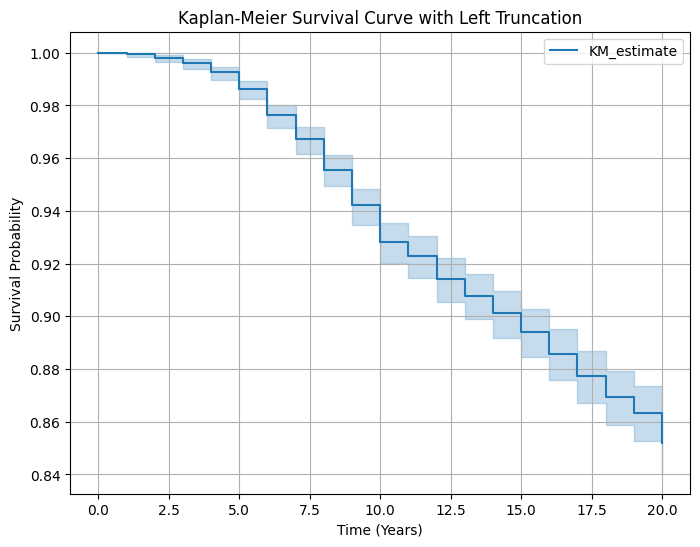

In [9]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

T = survival_data['survival_time']
E = survival_data['status']
entry = survival_data['entry_time']

kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E, entry=entry)

# Plot Kaplan-Meier survival curve
plt.figure(figsize=(8, 6))
kmf.plot()
plt.title('Kaplan-Meier Survival Curve with Left Truncation')
plt.xlabel('Time (Years)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


In [10]:
# !pip install seaborn
# 

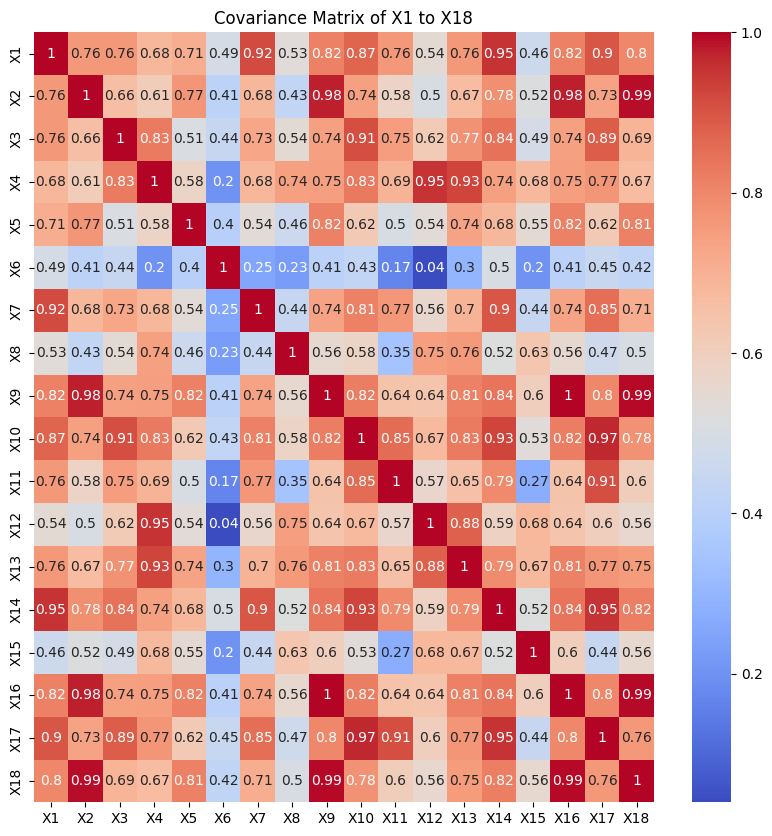

In [11]:
import seaborn as sns

import matplotlib.pyplot as plt

# Select columns X1 to X18
covariate_columns = [f'X{i}' for i in range(1, 19)]
covariance_matrix = survival_data[covariate_columns].corr()

# Plot the covariance matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(covariance_matrix, annot=True, cmap="coolwarm", cbar=True)
plt.title("Covariance Matrix of X1 to X18")
plt.savefig('fig/covariance_matrix.png')

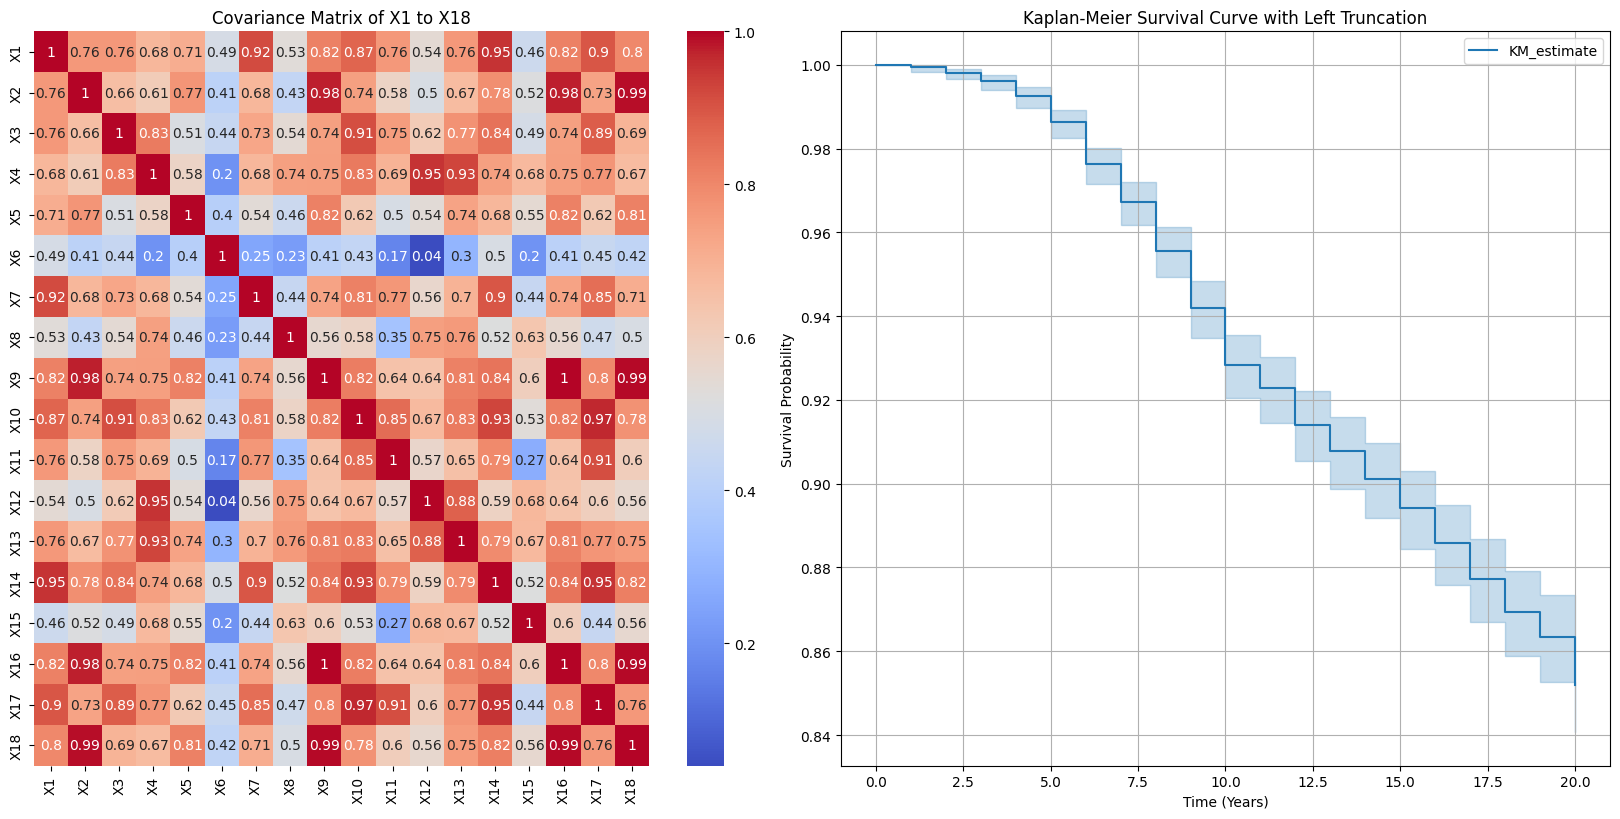

In [12]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns

# Kaplan-Meier Survival Curve with Left Truncation
T = survival_data['survival_time']
E = survival_data['status']
entry = survival_data['entry_time']

kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E, entry=entry)

# Covariance Matrix Heatmap for X1 to X18
covariate_columns = [f'X{i}' for i in range(1, 19)]
covariance_matrix = survival_data[covariate_columns].corr()

# Create a single figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot covariance matrix heatmap on the left
sns.heatmap(covariance_matrix, annot=True, cmap="coolwarm", cbar=True, ax=axes[0])
axes[0].set_title("Covariance Matrix of X1 to X18")

# Plot Kaplan-Meier survival curve on the right
kmf.plot(ax=axes[1])
axes[1].set_title('Kaplan-Meier Survival Curve with Left Truncation')
axes[1].set_xlabel('Time (Years)')
axes[1].set_ylabel('Survival Probability')
axes[1].grid(True)

# Adjust layout to remove margins
plt.tight_layout(pad=0)

# Save the figure
plt.savefig('fig/intro.png', bbox_inches='tight')
plt.show()

below: make `survival_data_adjusted` to remove infant mortality at $T=1 $

In [13]:
# import pandas as pd
# from lifelines import KaplanMeierFitter
# import matplotlib.pyplot as plt

# # Assuming 'survival_data' is your pandas DataFrame
# # and it has columns 'survival_time', 'status', and 'entry_time'

# # 1. Identify infants who died at t=1
# infant_mortality = (survival_data['survival_time'] == 1) & (survival_data['status'] == 1)

# # 2. Filter out these infants and create the new DataFrame
# survival_data_adjusted = survival_data[~infant_mortality].copy()

# # 3. Adjust entry times for survivors
# def adjust_entry_time(row):
#     if row['entry_time'] <= 1:
#         return 1
#     else:
#         return row['entry_time']

# survival_data_adjusted['adjusted_entry_time'] = survival_data_adjusted.apply(adjust_entry_time, axis=1)

# # Now, perform Kaplan-Meier analysis on the adjusted data
# T_adjusted = survival_data_adjusted['survival_time']
# E_adjusted = survival_data_adjusted['status']
# entry_adjusted = survival_data_adjusted['adjusted_entry_time']

# kmf_adjusted = KaplanMeierFitter()
# kmf_adjusted.fit(durations=T_adjusted, event_observed=E_adjusted, entry=entry_adjusted)

# # Plot the adjusted Kaplan-Meier survival curve
# plt.figure(figsize=(8, 6))
# kmf_adjusted.plot()
# plt.title('Kaplan-Meier Survival Curve Excluding Infant Mortality (t=1)')
# plt.xlabel('Time (Years)')
# plt.ylabel('Survival Probability (Conditional on Surviving Past t=1)')
# plt.grid(True)
# plt.show()

In [14]:
survival_data.to_csv('survival_data_adjusted.csv', index=False)

In [15]:
survival_data_adjusted = survival_data

In [16]:
# correlation matrix of survival_data_adjusted
correlation_matrix = survival_data_adjusted[[f'X{i}' for i in range(1,19)]].corr()
# correlation_matrix_is_1 = correlation_matrix[correlation_matrix == 1].stack().reset_index()
# plt.figure(figsize=(12, 10))
# plt.title('Correlation Matrix of Survival Data Adjusted')
# plt.imshow(correlation_matrix_is_1, cmap='coolwarm', interpolation='nearest')
# plt.colorbar()

In [17]:
correlation_matrix_larger_than_95 = np.array([1 if abs(correlation_matrix.iloc[i,j]) > 0.95 else 0 for i in range(len(correlation_matrix)) for j in range(len(correlation_matrix))]).reshape(len(correlation_matrix), len(correlation_matrix))
# plot heatmap of correlation matrix
print(correlation_matrix_larger_than_95)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0]
 [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1]]


see r's result because python leads to linalg error here/.

In [18]:
# # Prepare variables
# T = survival_data['survival_time']  # survival times
# E = survival_data['status']         # event occurred or censored (1 = failed, 0 = alive)

# # ========== Kaplan-Meier Estimation ==========
# kmf = KaplanMeierFitter()
# kmf.fit(durations=T, event_observed=E)

# # Plot Kaplan-Meier survival curve
# plt.figure(figsize=(8, 6))
# kmf.plot()
# plt.title('Kaplan-Meier Survival Curve')
# plt.xlabel('Time (Years)')
# plt.ylabel('Survival Probability')
# plt.grid(True)
# plt.show()

# # ========== Cox Proportional Hazards Model ==========
# Prepare data


from lifelines import CoxPHFitter

# Prepare the data, ensuring 'entry_time' is included
cox_data = survival_data_adjusted[['survival_time', 'entry_time', 'status',] + [f'X{i}' for i in range(1, 19)]]

# Initialize and fit the Cox model with left truncation adjustment
cph = CoxPHFitter()
# cph.fit(cox_data, duration_col='survival_time', event_col='status', entry_col='entry_time') # added left truncation

# Display the summary of the fitted model
# print(cph.summary)

In [19]:
# # cox_data = survival_data[['survival_time', 'status', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']]

# cph = CoxPHFitter()
# # cph.fit(cox_data, duration_col='survival_time', event_col='status')

# # Show Cox model summary
# print(cph.summary)

# # Plot Cox coefficients
# cph.plot()
# plt.title('Cox Model Coefficients')
# plt.show()


# import matplotlib.pyplot as plt
# import numpy as np

# # Extract hazard ratios and confidence intervals
# summary_df = cph.summary
# hr = summary_df['exp(coef)']
# ci_lower = summary_df['exp(coef) lower 95%']
# ci_upper = summary_df['exp(coef) upper 95%']

# # Sort by hazard ratio
# sorted_idx = hr.sort_values().index
# hr_sorted = hr.loc[sorted_idx]
# ci_lower_sorted = ci_lower.loc[sorted_idx]
# ci_upper_sorted = ci_upper.loc[sorted_idx]

# # Plot
# plt.figure(figsize=(8, 6))
# plt.barh(hr_sorted.index, hr_sorted.values, xerr=[hr_sorted.values - ci_lower_sorted.values, ci_upper_sorted.values - hr_sorted.values], align='center', alpha=0.7, ecolor='black', capsize=5)
# plt.axvline(x=1, color='grey', linestyle='--')
# plt.xlabel('Hazard Ratio (95% CI)')
# plt.title('Hazard Ratios with 95% Confidence Intervals')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [20]:
# # Extract p-values
# p_values = summary_df['p']

# # Compute -log10(p-values)
# neg_log_p = -np.log10(p_values)

# # Sort by -log10(p-values)
# neg_log_p_sorted = neg_log_p.sort_values()

# # Plot
# plt.figure(figsize=(8, 6))
# neg_log_p_sorted.plot(kind='barh', color='skyblue')
# plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', label='p = 0.05')
# plt.xlabel('-log10(p-value)')
# plt.title('Statistical Significance of Covariates')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [21]:
cox_data

,survival_time,entry_time,status,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,19,0,0,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,20,0,0,498.794,1459.008,385.568,964.345,91.846,168.903,317.518,...,2423.353,6608.506,2206.052,578.777,964.345,495.490,668.284,2423.353,4402.773,1459.008
2,15,0,0,23.527,17.916,5.252,19.892,0.892,9.488,7.967,...,40.252,71.001,0.000,14.640,22.336,11.512,45.705,40.252,15.896,20.360
3,20,0,0,1553.725,1908.784,137.696,813.734,295.255,425.764,1052.606,...,3991.997,4088.797,354.775,676.038,2083.213,1525.453,1839.085,3991.997,2397.304,3178.263
4,20,0,0,7965.500,34240.100,171.700,308.200,4149.300,723.700,3034.500,...,36712.500,10372.900,1439.600,136.500,2472.400,5121.800,1799.200,36712.500,6807.100,36404.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8966,7,0,0,1021.516,2924.860,147.393,722.886,404.120,328.528,494.747,...,4323.673,2636.487,337.764,575.493,1398.813,853.023,1007.326,4323.673,1839.319,3600.787
8967,3,0,0,91.467,112.583,3.280,11.787,63.282,4.182,26.040,...,140.605,129.924,62.648,8.507,28.022,32.778,26.019,140.605,99.033,128.818
8968,20,0,0,490.600,1231.300,57.400,253.300,234.200,103.300,213.900,...,2006.900,1188.800,241.400,195.900,775.600,470.600,208.600,2006.900,806.400,1753.600
8969,20,0,1,1468.808,1583.195,67.649,155.058,216.857,0.440,850.888,...,1891.088,3874.891,323.014,87.409,307.893,1302.406,-255.884,1891.088,3083.005,1736.030


 - the first way uses random split and assumes independence (but maybe temporal split is better, we attach this later
 )
 - second way: we cut from 2013

In [22]:
train, test = train_test_split(cox_data, test_size=0.2, random_state=42)

In [23]:
# # Fit model on train data with a specified solver to avoid linalg errors
# cph = CoxPHFitter(solver="lbfgs")  # Use the 'lbfgs' solver
# cph.fit(train, duration_col="survival_time", event_col="status")

# # Evaluate performance
# train_score = cph.concordance_index_
# test_score = cph.score(test, scoring_method="concordance_index")

# print(f"Train C-index: {train_score:.4f}")
# print(f"Test C-index: {test_score:.4f}")

In [24]:
# Set up candidate penalizer values for regularization tuning
penalizer_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
l1_ratio_values = [0.0, 0.25, 0.5, 0.75, 1.0]  # L2, Elastic Net, L1

# # Search over combinations of (penalizer, l1_ratio)
# best_score = -1
# best_model = None

# for penalizer in penalizer_values:
#     for l1_ratio in l1_ratio_values:
#         cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
#         scores = k_fold_cross_validation(cph, train, duration_col='survival_time', event_col='status', k=5, scoring_method="concordance_index")
#         avg_score = sum(scores) / len(scores)
#         print(f"penalizer={penalizer}, l1_ratio={l1_ratio} --> CV C-index: {avg_score:.4f}")
        
#         if avg_score > best_score:
#             best_score = avg_score
#             best_model = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)

# # Fit best model on train set
# best_model.fit(train, duration_col="survival_time", event_col="status")

# # Evaluate on test set
# test_c_index = best_model.score(test, scoring_method="concordance_index")
# print(f"\nBest Model Test C-index: {test_c_index:.4f}")

# # Show summary
# print(best_model.summary)


# Temporal Split

In [25]:
# from itertools import product

In [26]:
# !pip install rpy2


In [27]:
train

,survival_time,entry_time,status,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
1817,19,14,0,15.141,2.117,0.030,-4.033,0.520,-9.552,0.252,...,1.892,15.836,0.000,-4.063,-0.225,1.001,-16.600,1.892,1.001,5.925
737,3,0,0,1075.184,68.044,18.860,130.527,0.000,85.314,148.818,...,572.190,1225.776,500.000,111.667,504.146,243.326,-70.563,572.190,744.994,441.663
4271,7,0,1,32.220,171.177,4.429,12.097,0.000,2.911,28.536,...,224.564,68.786,22.885,7.668,53.387,26.231,4.803,224.564,51.417,212.467
2407,20,0,0,5.694,0.299,0.315,0.286,0.000,0.325,0.333,...,1.574,7.729,0.000,-0.029,1.275,0.088,7.546,1.574,0.215,1.288
5816,19,1,0,0.098,2.181,0.044,-2.168,0.000,-2.542,0.000,...,0.013,0.543,0.739,-2.212,-2.168,0.121,-3.980,0.013,0.860,2.181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,20,0,0,104.243,201.605,7.460,49.733,39.717,26.805,17.995,...,293.236,176.101,17.057,42.273,91.631,47.357,78.057,293.236,79.808,243.503
5191,3,0,0,65.632,194.023,9.994,36.549,29.695,10.216,29.787,...,272.603,207.562,77.060,26.555,78.580,35.862,13.058,272.603,126.808,236.054
5390,1,0,0,9.971,1.026,1.308,-4.265,5.054,-4.675,0.640,...,3.551,15.471,0.005,-5.573,2.525,4.185,-51.094,3.551,4.190,7.816
860,20,0,0,54.185,243.162,6.956,38.890,33.382,17.191,11.303,...,324.455,156.044,44.630,31.934,81.293,25.215,64.999,324.455,71.955,285.565


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

# Collect the results in a DataFrame
results = []
# Set up candidate penalizer values for regularization tuning
penalizer_values = np.logspace(-3, 1, 10)  # 10 values between 10^-3 and 10^1
l1_ratio_values = np.linspace(0.0, 1.0, 10)  # 10 values between 0.0 and 1.0

# Time series split setup
time_split = TimeSeriesSplit(n_splits=5)

# Search over combinations of (penalizer, l1_ratio)
best_score = -1
best_model = None


for penalizer in penalizer_values:
    for l1_ratio in l1_ratio_values:
        cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
        
        # Perform time series cross-validation
        scores = []
        for train_index, test_index in time_split.split(train):
            train_fold = train.iloc[train_index]
            test_fold = train.iloc[test_index]
            
            cph.fit(train_fold, duration_col='survival_time', event_col='status', entry_col='entry_time')
            score = cph.score(test_fold, scoring_method="concordance_index")
            scores.append(score)
        
        avg_score = sum(scores) / len(scores)
        print(f"penalizer={penalizer}, l1_ratio={l1_ratio} --> CV C-index: {avg_score:.4f}")
        
        results.append({'penalizer': penalizer, 'l1_ratio': l1_ratio, 'c_index': avg_score})
        
        if avg_score > best_score:
            best_score = avg_score
            best_model = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(10, 6))
for l1_ratio in l1_ratio_values:
    subset = results_df[results_df['l1_ratio'] == l1_ratio]
    plt.plot(subset['penalizer'], subset['c_index'], marker='o', label=f'L1 ratio = {l1_ratio}')

plt.xscale('log')
plt.xlabel('Penalizer (log scale)')
plt.ylabel('Cross-Validated C-index')
plt.title('Cox Model Hyperparameter Tuning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('fig/cox_model_hyperparameter_tuning.png')

penalizer=0.001, l1_ratio=0.0 --> CV C-index: 0.5432
penalizer=0.001, l1_ratio=0.1111111111111111 --> CV C-index: 0.5441
penalizer=0.001, l1_ratio=0.2222222222222222 --> CV C-index: 0.5448
penalizer=0.001, l1_ratio=0.3333333333333333 --> CV C-index: 0.5448
penalizer=0.001, l1_ratio=0.4444444444444444 --> CV C-index: 0.5425
penalizer=0.001, l1_ratio=0.5555555555555556 --> CV C-index: 0.5422
penalizer=0.001, l1_ratio=0.6666666666666666 --> CV C-index: 0.5439
penalizer=0.001, l1_ratio=0.7777777777777777 --> CV C-index: 0.5454
penalizer=0.001, l1_ratio=0.8888888888888888 --> CV C-index: 0.5469
penalizer=0.001, l1_ratio=1.0 --> CV C-index: 0.5484
penalizer=0.0027825594022071257, l1_ratio=0.0 --> CV C-index: 0.5472
penalizer=0.0027825594022071257, l1_ratio=0.1111111111111111 --> CV C-index: 0.5443
penalizer=0.0027825594022071257, l1_ratio=0.2222222222222222 --> CV C-index: 0.5405
penalizer=0.0027825594022071257, l1_ratio=0.3333333333333333 --> CV C-index: 0.5397
penalizer=0.00278255940220712

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# Assume 'train' dataframe exists with 'survival_time', 'status', and feature columns


# Set up candidate penalizer values for regularization tuning
penalizer_values = np.logspace(-3, 1, 10)  # 10 values between 10^-3 and 10^1
l1_ratio_values = np.linspace(0.0, 1.0, 10)  # 10 values between 0.0 and 1.0

# Results storage
results = []
best_aic = np.inf
best_model = None

# Search for the best penalization combination by partial AIC
for penalizer in penalizer_values:
    for l1_ratio in l1_ratio_values:
        cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
        cph.fit(train, duration_col='survival_time', event_col='status',
                entry_col='entry_time', show_progress=False)
        aic = cph.AIC_partial_
        results.append({'penalizer': penalizer, 'l1_ratio': l1_ratio, 'AIC_partial': aic})

        if aic < best_aic:
            best_aic = aic
            best_model = cph

# Display the results sorted by partial AIC
results_df = pd.DataFrame(results).sort_values(by='AIC_partial')
print("Model ranking by partial AIC:")
print(results_df)

# Extract and print formula from best model
selected_features = best_model.params_[best_model.params_ != 0].index.tolist()
formula_str = "surv_obj ~ " + " + ".join(selected_features)
print("\nBest formula by partial AIC:", formula_str)

# Extract hazard ratios and confidence intervals
summary_df = best_model.summary
hr = summary_df['exp(coef)']
ci_lower = summary_df['exp(coef) lower 95%']
ci_upper = summary_df['exp(coef) upper 95%']

# Sort by hazard ratio
sorted_idx = hr.sort_values().index
hr_sorted = hr.loc[sorted_idx]
ci_lower_sorted = ci_lower.loc[sorted_idx]
ci_upper_sorted = ci_upper.loc[sorted_idx]

# Plot hazard ratios with confidence intervals
plt.figure(figsize=(8, len(hr_sorted) * 0.5 + 2))
plt.barh(hr_sorted.index, hr_sorted.values,
         xerr=[hr_sorted.values - ci_lower_sorted.values, ci_upper_sorted.values - hr_sorted.values],
         align='center', alpha=0.7, ecolor='black', capsize=5)
plt.axvline(x=1, color='grey', linestyle='--')
plt.xlabel('Hazard Ratio (95% CI)')
plt.title('Hazard Ratios with 95% Confidence Intervals (Best Cox Model by partial AIC)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Extract p-values
p_values = summary_df['p']

# Compute -log10(p-values)
neg_log_p = -np.log10(p_values)

# Sort by -log10(p-values)
neg_log_p_sorted = neg_log_p.sort_values()

# Plot statistical significance of covariates
plt.figure(figsize=(8, len(neg_log_p_sorted) * 0.5 + 2))
neg_log_p_sorted.plot(kind='barh', color='skyblue')
plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', label='p = 0.05')
plt.xlabel('-log10(p-value)')
plt.title('Statistical Significance of Covariates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('fig/statistical_significance_of_covars_selected_by_penalizations.png')

KeyboardInterrupt: 

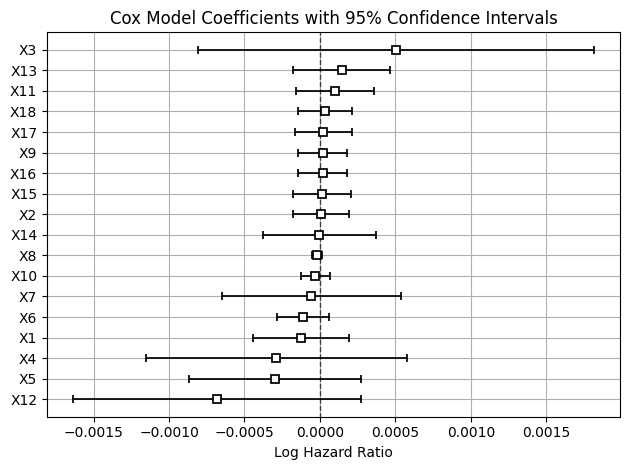

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'best_model' is your fitted CoxPHFitter instance
ax = best_model.plot()
plt.title('Cox Model Coefficients with 95% Confidence Intervals')
plt.xlabel('Log Hazard Ratio')
plt.grid(True)
plt.tight_layout()
plt.savefig('fig/cox_model_coefficients_CI_from_penalizated_model.png')
